In [2]:
!pip install xgboost
!pip install plotnine

Keyring is skipped due to an exception: 'keyring.backends'
Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
import sys
import os
import glob
import numpy as np
import plotnine
from plotnine import *

# Hardcode so we can use in any notebook
module_path = "/root/HAIP/services"
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# from sharepoint_transfer.src import main as sharepoint_transfer_svc
from data_consolidation.src import main as data_consolidation_svc
from feature_engineering.src import main as feature_engineering_svc
from model_selection.src import main as model_selection_svc
from outcome_analysis.src import main as outcome_analysis_svc
from model_training.src import main as model_training_svc
from final_fitting.src import main as final_fitting_svc
from ensemble_model.src import main as ensemble_model_svc

from model_dataset.src.main import load_dataframe
from artificial_anomaly_tests.aa_tests import artificial_anomaly_test_xgb
from model_training import xgbr_test

## Set Measure Specific Settings

These will augment and override settings in "/root/HAIP/notebooks/services/config.json"

In [5]:
SKIP_TUNING = True
SKIP_RMSE_TEST = False

settings = {
    # Measure specific options
    "MEASURE_SPECIFIC_FILENAME": "SEP-1.csv",
    "FULL_MEASURE_S3_PREFIX": "SEP-1",
    "filter_measure": "SEP_1", # make sure this is _ not -
    
    "run_save_path": "model_runs",
    "shift_range": range(30, 50), # for isolation_forest
    
    # Feature Engineering options
    "backfill_prov_mean": False, # set to false to not backfill prov mean
    "backfill_lag": False, # set to false to not backfill lag
    "lag_to_add": 2, # add lag1/lag2
}

settings['save_modeling_dataset_path'] = f"/root/HAIP/data/{settings.get('MEASURE_SPECIFIC_FILENAME')}"
settings['model_dataset_path'] = settings['save_modeling_dataset_path']

## Move Sharepoint files to S3

This is not possible in SageMaker Studio because we are trying to figure out Client ID/Secret for the Sharepoint REST API. For now, run the service locally using your own Office365 username/password

## Data Consolidation

Make sure the measure `settings` are changed.


Call `data_consolidation_main.main(settings)`


This will download the full-measure-data in S3, load it into a single data frame, normalize the columns, filter to only include `filter_measure` and then upload the result to S3.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-measure-specific-data?region=us-east-1&tab=objects

In [6]:
# data_consolidation_svc.main(settings)

## Feature Engineering

Call `feature_engineering_main.main(settings)`

This will download the consolidated measure-specific-data in S3, normalize the columns, and add the new features, then upload the result to S3.
Results should also be saved locally automatically, but that is not yet implemented. For now download from the link below and upload the file to SageMaker Studio.


Result csv and metadata are uploaded to https://s3.console.aws.amazon.com/s3/buckets/haip-modeling-dataset?region=us-east-1&tab=objects

In [7]:
# feature_engineering_svc.main(settings)

## XGBoost Regression

### Feature Importance

In [8]:
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression", 
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2, 0.3]],
        'gamma': [range(0, 3)],  # [range(0, 2)]
        'max_depth': [range(5, 10)],  # [range(5, 9)]
        'min_child_weight': [range(3, 10)],  # [range(3, 9)]
        'subsample': [[1]],
        'alpha': [[0, 1, 2]]
    },
    "drop_cols": ['provider_id', 'lag_diff', 'prov_mean_diff'],
}

settings = {**settings, **xgbr_feature_importance_settings}

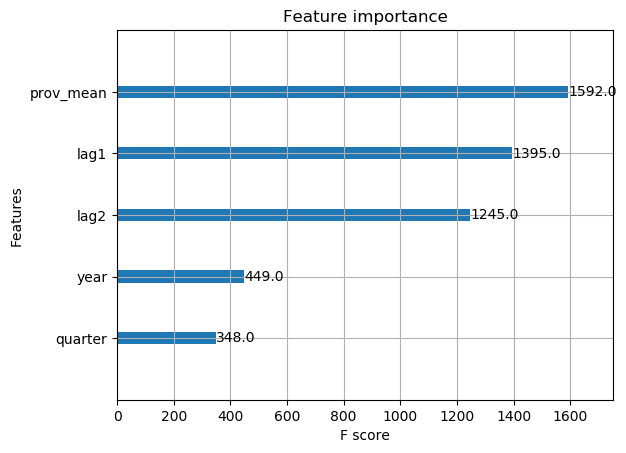

In [9]:
xgbr_tuner = model_training_svc.get_model_trainer(settings)
xgbr_tuner.plot_feature_importance()

In [10]:
xgbr_drop_cols = ['provider_id', 'lag2', 'lag_diff', 'prov_mean_diff', 'year', 'quarter']
xgbr_feature_importance_settings = {
    "model_type": "XGBRegression",
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_feature_importance_settings}

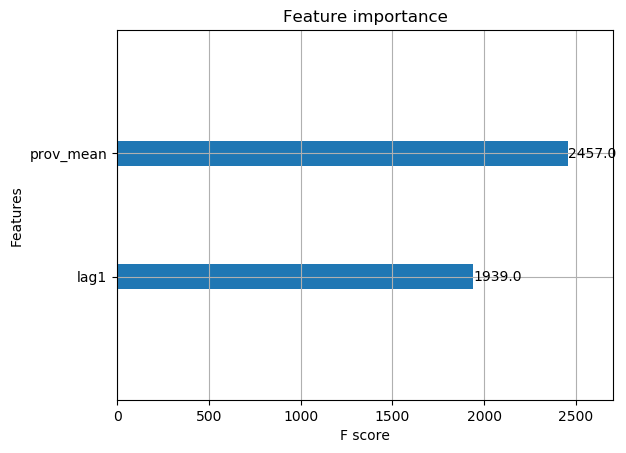

In [11]:
xgbr_tuner = model_training_svc.get_model_trainer(settings)
xgbr_tuner.plot_feature_importance()

### Tuning

In [12]:
candidate = None
# if not SKIP_TUNING:
#     candidate = xgbr_tuner.tune()

In [13]:
candidate

### Model Selection

Make sure `model_run_data_path` is set in settings to the tuning result path.
Make sure `model_type` is set in settings to `XGBRegression`, `Isolation Forest`, or `Ensemble`

Call `model_selector = model_selection_main.get_model_selector(settings)` to get the appropriate selector.
Then call `model_selector.get_top_models()` to get the top models

To get the candidate model that matches one of the top_model:
     Call `model_selector.get_candidate_model_by_index(INDEX)` to get the candidate model
     Call `model_selector.get_candidate_model_params_by_index(INDEX)` to get the candidate model params

For `model_run_data_path` right click the file in side nav and choose `Copy Path`. Paste that and add a `/root/` before it.

In [14]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgboost_regression/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgboost_regression/tuning_results_run_2022-11-28-14h25m.csv


In [15]:
xgbr_model_selector = model_selection_svc.get_model_selector(settings)
xgbr_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
422,-6.1666,0.1098,1,1,0.05,0,5,5,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
876,-6.1666,0.1110,2,2,0.05,1,5,4,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
841,-6.1667,0.1105,3,2,0.05,0,5,4,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
842,-6.1668,0.1095,5,2,0.05,0,5,5,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 0, 'max_dep..."
457,-6.1668,0.1099,4,1,0.05,1,5,5,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 1, 'max_dep..."
913,-6.1669,0.1108,6,2,0.05,2,5,6,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
911,-6.1669,0.1107,7,2,0.05,2,5,4,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
879,-6.1670,0.1098,8,2,0.05,1,5,7,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
492,-6.1670,0.1100,9,1,0.05,2,5,5,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 2, 'max_dep..."
36,-6.1670,0.1107,10,0,0.05,1,5,4,1,"{'alpha': 0, 'eta': 0.05, 'gamma': 1, 'max_dep..."


In [16]:
xgbr_model_index = 876
#xgbr_model_index = xgbr_model_selector.get_top_models().iloc[0].name # default top model
xgbr_model_selector.get_candidate_model_by_index(xgbr_model_index)

mean_fit_time         2.2115
std_fit_time          0.0922
mean_score_time       0.0252
std_score_time        0.0009
param_alpha                2
                       ...  
split48_test_score   -6.2426
split49_test_score   -6.1004
mean_test_score      -6.1666
std_test_score         0.111
rank_test_score            2
Name: 876, Length: 64, dtype: object

In [17]:
xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index)

{'alpha': 2,
 'eta': 0.05,
 'gamma': 1,
 'max_depth': 5,
 'min_child_weight': 4,
 'subsample': 1}

### Final Fit

In [18]:
xgbr_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": xgbr_model_selector.get_candidate_model_params_by_index(xgbr_model_index),
    "drop_cols": xgbr_drop_cols,
}

settings = {**settings, **xgbr_final_fit_settings}

In [19]:
xgbr_fitter = final_fitting_svc.get_final_fitter(settings)
xgbr_model = xgbr_fitter.fit()

In [20]:
xgbr_model

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.05,
             eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.0500000007, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

### Threshold / AAT Results

In [21]:
threshold_range = range(1,100)

xgbr_aat_res = artificial_anomaly_test_xgb(
    model = xgbr_model, 
    model_data = xgbr_fitter.modeling_df,
    selected_features = ['lag1', 'prov_mean'],
    shift_range = settings.get('shift_range'),
    threshold_range = threshold_range
)[:5]

#xgbr_threshold = xgbr_aat_res.iloc[0]['Threshold']
xgbr_threshold = 10
print("Using Threshold", xgbr_threshold)

xgbr_aat_res

Using Threshold 10


,Threshold,AUROC
7,8,0.821000
8,9,0.820900
6,7,0.817375
9,10,0.816250
10,11,0.809000


### CV RMSE

In [22]:
xgbr_cv_rmse = None
if not SKIP_RMSE_TEST:
    _, xgbr_cv_rmse = xgbr_test.test_xgbr(xgbr_fitter.modeling_df)
xgbr_cv_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.9s finished


6.282878016364256

## Isolation Forest

### Tuning

In [23]:
if_drop_cols = ['provider_id', 'lag2', 'year', 'quarter']
if_training_settings = {
    "model_type": "Isolation Forest", 
    "if_parameters": {
        # Features to include
        'features_included': [['lag_diff', 'prov_mean_diff']],
        # The number of base estimators in the ensemble.
        'n_estimators': [50, 100, 200, 300],
        # The number of samples to draw from X to train each base estimator.
        'max_samples': ['auto', 200, 175, 128],
        # The number of features to draw from X to train each base estimator.
        'max_features': [1],
        # If True, individual trees are fit on random subsets of the training data sampled with replacement.
        # If False, sampling without replacement is performed.
        'bootstrap': [False, True]
    },
    "drop_cols": if_drop_cols, # use just lag1, prov_mean
}

settings = {**settings, **if_training_settings}

In [24]:
if_trainer = model_training_svc.get_model_trainer(settings)

In [25]:
candidate = None
# if not SKIP_TUNING:
#     candidate = if_trainer.tune()

In [26]:
candidate

### Model Selection

In [27]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/isolation_forest/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

if_settings = {
    "model_run_data_path": latest_run,    
    "model_type": "Isolation Forest"
}

settings = {**settings, **if_settings}

Using result:  model_runs/isolation_forest/tuning_results_run_2022-11-28-15h02m.csv


In [28]:
if_model_selector = model_selection_svc.get_model_selector(settings)
if_model_selector.get_top_models()

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
6,False,"[lag_diff, prov_mean_diff]",1,200,200,7,0.9959,0.9070,0.9202,0.9317,0.9400,0.9479,0.9546,0.9605,0.9646,0.9672,0.9694,0.9715,0.9729,0.9735,0.9740,0.9737,0.9729
9,False,"[lag_diff, prov_mean_diff]",1,175,100,10,0.9959,0.9007,0.9151,0.9280,0.9376,0.9464,0.9532,0.9586,0.9626,0.9668,0.9699,0.9718,0.9732,0.9737,0.9742,0.9743,0.9728
11,False,"[lag_diff, prov_mean_diff]",1,175,300,12,0.9959,0.9033,0.9164,0.9286,0.9379,0.9463,0.9532,0.9589,0.9630,0.9664,0.9691,0.9709,0.9722,0.9731,0.9739,0.9737,0.9730
19,True,"[lag_diff, prov_mean_diff]",1,auto,300,20,0.9959,0.9167,0.9276,0.9378,0.9459,0.9525,0.9584,0.9630,0.9666,0.9692,0.9712,0.9728,0.9737,0.9743,0.9741,0.9738,0.9727
2,False,"[lag_diff, prov_mean_diff]",1,auto,200,3,0.9958,0.9161,0.9271,0.9378,0.9456,0.9526,0.9583,0.9630,0.9669,0.9687,0.9711,0.9727,0.9735,0.9741,0.9737,0.9732,0.9720
3,False,"[lag_diff, prov_mean_diff]",1,auto,300,4,0.9958,0.9169,0.9288,0.9387,0.9461,0.9527,0.9582,0.9626,0.9664,0.9688,0.9709,0.9725,0.9735,0.9744,0.9742,0.9735,0.9723
7,False,"[lag_diff, prov_mean_diff]",1,200,300,8,0.9958,0.9096,0.9218,0.9332,0.9414,0.9492,0.9559,0.9607,0.9648,0.9676,0.9698,0.9714,0.9726,0.9733,0.9736,0.9734,0.9724
21,True,"[lag_diff, prov_mean_diff]",1,200,100,22,0.9958,0.9041,0.9188,0.9302,0.9405,0.9478,0.9545,0.9598,0.9638,0.9671,0.9696,0.9717,0.9732,0.9735,0.9735,0.9730,0.9719
23,True,"[lag_diff, prov_mean_diff]",1,200,300,24,0.9958,0.9091,0.9220,0.9331,0.9417,0.9493,0.9554,0.9604,0.9647,0.9675,0.9695,0.9715,0.9725,0.9732,0.9734,0.9732,0.9723
27,True,"[lag_diff, prov_mean_diff]",1,175,300,28,0.9958,0.9033,0.9161,0.9281,0.9378,0.9458,0.9525,0.9581,0.9621,0.9652,0.9679,0.9701,0.9713,0.9724,0.9732,0.9732,0.9727


In [29]:
# if_model_id = 6
if_model_id = if_model_selector.get_top_models().iloc[0].model_id # default top model
if_model_selector.get_candidate_model_by_index(if_model_id)

,bootstrap,features_included,max_features,max_samples,n_estimators,model_id,auroc_total,auroc_threshold_0.5,auroc_threshold_0.51,auroc_threshold_0.52,auroc_threshold_0.53,auroc_threshold_0.54,auroc_threshold_0.55,auroc_threshold_0.56,auroc_threshold_0.57,auroc_threshold_0.58,auroc_threshold_0.59,auroc_threshold_0.6,auroc_threshold_0.61,auroc_threshold_0.62,auroc_threshold_0.63,auroc_threshold_0.64,auroc_threshold_0.65
6,False,"[lag_diff, prov_mean_diff]",1,200,200,7,0.9959,0.907,0.9202,0.9317,0.94,0.9479,0.9546,0.9605,0.9646,0.9672,0.9694,0.9715,0.9729,0.9735,0.974,0.9737,0.9729


In [30]:
if_model_selector.get_candidate_model_params_by_index(if_model_id)

{'bootstrap': False,
 'features_included': ['lag_diff', 'prov_mean_diff'],
 'max_features': 1,
 'max_samples': 200,
 'n_estimators': 200}

### Final Fit

In [31]:
if_final_fit_settings = {
    "model_type": "Isolation Forest",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "if_final_params": if_model_selector.get_candidate_model_params_by_index(if_model_id),
    "drop_cols": if_drop_cols,
}

del if_final_fit_settings['if_final_params']['features_included']

settings = {**settings, **if_final_fit_settings}

In [32]:
if_fitter = final_fitting_svc.get_final_fitter(settings)
if_model = if_fitter.fit()

In [33]:
if_model

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1, max_samples=200, n_estimators=200, n_jobs=-1,
                random_state=RandomState(MT19937) at 0x7F7997C247C0, verbose=0,
                warm_start=False)

In [34]:
if_anomaly_scores = if_fitter.get_anomaly_scores()
if_anomaly_scores

array([0.52616452, 0.53036433, 0.53846621, ..., 0.44341108, 0.45412502,
       0.45815465])

### Threshold

In [35]:
# _candidate = if_model_selector.get_candidate_model_by_index(if_model_id)
# _candidate = _candidate.drop(columns=[col for col in _candidate.columns if 'auroc_threshold_' not in col])

# highest_auroc = _candidate.max().max()
# threshold_col_name = None
# for col in _candidate.columns:
#     if _candidate[col].item() == highest_auroc:
#         threshold_col_name = col
#         break

# if threshold_col_name is None:
#     print("Could not find threshold for Isolation Forest")
# else:
#     if_threshold = float(threshold_col_name.replace('auroc_threshold_', ''))
#     print("Using threshold", if_threshold, "based on highest value", highest_auroc)

## Ensemble Model

### Feature Importance

In [36]:
ensemble_settings = {
    "xgbr_parameters": {
        'eta': [[0.05, 0.1, 0.2, 0.3]],
        'gamma': [range(0, 3)],  # [range(0, 2)]
        'max_depth': [range(5, 10)],  # [range(5, 9)]
        'min_child_weight': [range(3, 10)],  # [range(3, 9)]
        'subsample': [[1]],
        'alpha': [[0, 1, 2]]
    },
    "drop_cols": ['provider_id', 'lag_diff', 'prov_mean_diff'],
    "if_model": if_model,
    "if_anomaly_scores": if_anomaly_scores,
}

settings = {**settings, **ensemble_settings}

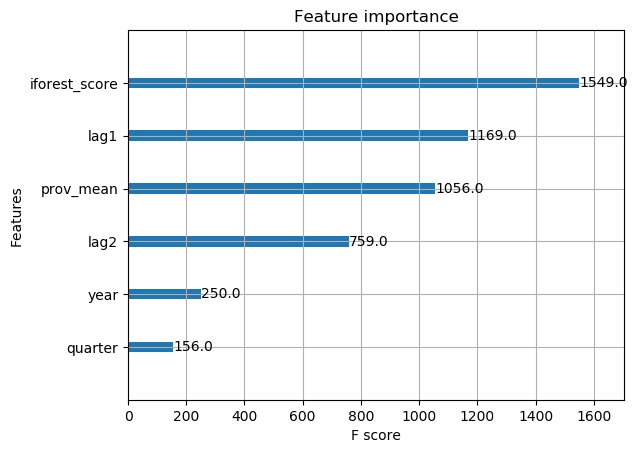

In [37]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

In [38]:
ensemble_drop_cols = ['provider_id', 'lag2', 'prov_mean_diff', 'year', 'quarter', 'lag_diff']
ensemble_settings = {
    "drop_cols": ensemble_drop_cols
}

settings = {**settings, **ensemble_settings}

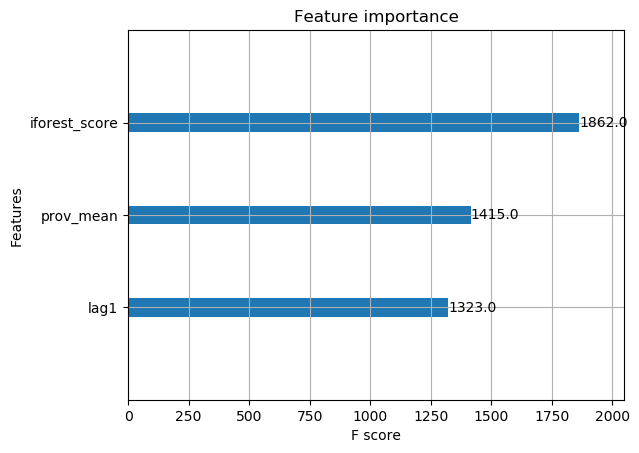

In [39]:
ensemble_trainer = ensemble_model_svc.get_ensemble_trainer(settings)
ensemble_trainer.plot_feature_importance()

### Tuning

In [40]:
candidate = None
# if not SKIP_TUNING:
#     candidate = ensemble_trainer.tune()

In [41]:
candidate

In [42]:
ensemble_trainer.modeling_df

,score,lag1,prov_mean,iforest_score
1,19.0,18.0,18.000000,0.526165
2,18.0,19.0,18.500000,0.530364
3,26.0,18.0,18.333333,0.538466
4,32.0,26.0,20.250000,0.515457
5,36.0,32.0,22.600000,0.499288
...,...,...,...,...
42330,59.0,61.0,49.222222,0.444381
42331,62.0,59.0,50.200000,0.448470
42332,62.0,62.0,51.272727,0.443411
42333,65.0,62.0,52.166667,0.454125


### Model Selection

In [43]:
list_of_runs = glob.glob(f"{settings.get('run_save_path')}/xgbr_ensemble/*.csv")
latest_run = max(list_of_runs, key=os.path.getctime)
print("Using result: ", latest_run)

xgbr_settings = {
    "model_run_data_path": latest_run,
    "model_type": "XGBRegression"
}

settings = {**settings, **xgbr_settings}

Using result:  model_runs/xgbr_ensemble/tuning_results_run_2022-11-28-15h09m.csv


In [44]:
ensemble_model_selector = model_selection_svc.get_model_selector(settings)
ensemble_model_selector.get_top_models()

,mean_test_score,std_test_score,rank_test_score,param_alpha,param_eta,param_gamma,param_max_depth,param_min_child_weight,param_subsample,params
951,-5.8921,0.1176,1,2,0.10,0,5,9,1,"{'alpha': 2, 'eta': 0.1, 'gamma': 0, 'max_dept..."
1021,-5.8938,0.1197,2,2,0.10,2,5,9,1,"{'alpha': 2, 'eta': 0.1, 'gamma': 2, 'max_dept..."
913,-5.8941,0.1230,3,2,0.05,2,5,6,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
880,-5.8941,0.1244,4,2,0.05,1,5,8,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 1, 'max_dep..."
566,-5.8942,0.1250,5,1,0.10,1,5,9,1,"{'alpha': 1, 'eta': 0.1, 'gamma': 1, 'max_dept..."
440,-5.8942,0.1277,6,1,0.05,0,7,9,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."
986,-5.8945,0.1197,7,2,0.10,1,5,9,1,"{'alpha': 2, 'eta': 0.1, 'gamma': 1, 'max_dept..."
915,-5.8948,0.1245,9,2,0.05,2,5,8,1,"{'alpha': 2, 'eta': 0.05, 'gamma': 2, 'max_dep..."
601,-5.8948,0.1238,8,1,0.10,2,5,9,1,"{'alpha': 1, 'eta': 0.1, 'gamma': 2, 'max_dept..."
425,-5.8949,0.1217,10,1,0.05,0,5,8,1,"{'alpha': 1, 'eta': 0.05, 'gamma': 0, 'max_dep..."


In [45]:
ensemble_model_index = 1021
#ensemble_model_index = ensemble_model_selector.get_top_models().iloc[0].name # default top model
ensemble_model_selector.get_candidate_model_by_index(ensemble_model_index)

mean_fit_time         2.9309
std_fit_time          0.8023
mean_score_time        0.023
std_score_time        0.0058
param_alpha                2
                       ...  
split48_test_score    -5.943
split49_test_score   -5.8413
mean_test_score      -5.8938
std_test_score        0.1197
rank_test_score            2
Name: 1021, Length: 64, dtype: object

In [46]:
ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index)

{'alpha': 2,
 'eta': 0.1,
 'gamma': 2,
 'max_depth': 5,
 'min_child_weight': 9,
 'subsample': 1}

### Final Fit

In [47]:
ensemble_final_fit_settings = {
    "model_type": "XGBRegression",
    "model_dataset_path": settings.get('save_modeling_dataset_path'),
    "xgbr_final_params": ensemble_model_selector.get_candidate_model_params_by_index(ensemble_model_index),
    "drop_cols": ensemble_drop_cols,
}

settings = {**settings, **ensemble_final_fit_settings}

In [48]:
ensemble_fitter = ensemble_model_svc.get_ensemble_final_fitter(settings)
ensemble_model = ensemble_fitter.fit()

In [49]:
ensemble_model

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=9,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

### Threshold / AAT Results

In [50]:
threshold_range = range(1,100)

ensemble_aat_res = artificial_anomaly_test_xgb(
    model = ensemble_model,
    model_data = ensemble_fitter.modeling_df,
    selected_features = ['lag1','prov_mean', 'iforest_score'],
    shift_range = settings.get('shift_range'),
    threshold_range = threshold_range
)[:5]

#ensemble_threshold = ensemble_aat_res.iloc[0]['Threshold']
ensemble_threshold = 9
print("Using Threshold", ensemble_threshold)

ensemble_aat_res

Using Threshold 9


,Threshold,AUROC
7,8,0.833450
6,7,0.833075
8,9,0.830400
9,10,0.825375
5,6,0.822150


### CV RMSE

In [51]:
ensemble_cv_rmse = None
if not SKIP_RMSE_TEST:
    _, ensemble_cv_rmse = xgbr_test.test_xgbr(ensemble_fitter.modeling_df)
ensemble_cv_rmse

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.9s finished


5.946803228912315

## Outcome Analysis

In [52]:
outcome_analysis_settings = {
    "if_model": if_model,
    "if_threshold": .6,

    "xgbr_model": xgbr_model,
    "xgbr_threshold": xgbr_threshold,
    
    "ensemble_model": ensemble_model,
    "ensemble_threshold": ensemble_threshold,
}

settings = {**settings, **outcome_analysis_settings}

In [53]:
modeling_dataset = load_dataframe(settings.get('model_dataset_path'), []).dropna(subset = ['lag1'])
modeling_dataset['y_quarter'] = modeling_dataset['year'].astype(str) + 'Q' + modeling_dataset['quarter'].astype(str)
modeling_dataset

,provider_id,score,lag1,lag2,year,quarter,lag_diff,prov_mean,prov_mean_diff,y_quarter
1,100001,19.0,18.0,NaN,2017,4,1.0,18.000000,1.000000,2017Q4
2,100001,18.0,19.0,18.0,2018,1,-1.0,18.500000,-0.500000,2018Q1
3,100001,26.0,18.0,19.0,2018,2,8.0,18.333333,7.666667,2018Q2
4,100001,32.0,26.0,18.0,2018,3,6.0,20.250000,11.750000,2018Q3
5,100001,36.0,32.0,26.0,2018,4,4.0,22.600000,13.400000,2018Q4
...,...,...,...,...,...,...,...,...,...,...
42330,90011,59.0,61.0,65.0,2019,4,-2.0,49.222222,9.777778,2019Q4
42331,90011,62.0,59.0,61.0,2020,3,3.0,50.200000,11.800000,2020Q3
42332,90011,62.0,62.0,59.0,2020,4,0.0,51.272727,10.727273,2020Q4
42333,90011,65.0,62.0,62.0,2021,1,3.0,52.166667,12.833333,2021Q1


In [54]:
xgbr_scores = xgbr_model.predict(modeling_dataset[['lag1','prov_mean']])
xgbr_prediction = abs(modeling_dataset['score'] - xgbr_scores) > settings.get('xgbr_threshold')

xgbr_dataset = modeling_dataset.copy()[['score','y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
xgbr_dataset['outlier'] = xgbr_prediction
xgbr_dataset['model_score'] = xgbr_scores
xgbr_dataset['model'] = "XGBoost Regression"
xgbr_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.141809,XGBoost Regression
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.872658,XGBoost Regression
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,False,20.141809,XGBoost Regression
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.839346,XGBoost Regression
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.243614,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
42330,59.0,2019Q4,90011,49.222222,-2.0,9.777778,False,61.391804,XGBoost Regression
42331,62.0,2020Q3,90011,50.200000,3.0,11.800000,False,59.290680,XGBoost Regression
42332,62.0,2020Q4,90011,51.272727,0.0,10.727273,False,62.016937,XGBoost Regression
42333,65.0,2021Q1,90011,52.166667,3.0,12.833333,False,61.966015,XGBoost Regression


### Insample RMSE

||New XGBoost Ensemble|Prev XGBoost Regression|
|---|---|---|
|In-sample RMSE|5.44|5.44|
|In-sample MAE|1.95|1.92|

#### XGBoost Regression

In [55]:
import pandas as pd

rmse = np.sqrt(np.mean((xgbr_dataset['score'] - xgbr_dataset['model_score'])**2))
mae = np.sqrt(np.mean(abs(xgbr_dataset['score'] - xgbr_dataset['model_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

,RMSE,MAE
0,6.048023,2.045957


#### Ensemble Model

In [56]:
# rmse = np.sqrt(np.mean((ensemble_dataset['score'] - ensemble_dataset['model_score'])**2))
# mae = np.sqrt(np.mean(abs(ensemble_dataset['score'] - ensemble_dataset['model_score'])))

# pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

#### Previous XG Boost Regression

In [57]:
# rmse = np.sqrt(np.mean((xgb_sep01_dataset['score'] - xgb_sep01_dataset['predicted_score'])**2))
# mae = np.sqrt(np.mean(abs(xgb_sep01_dataset['score'] - xgb_sep01_dataset['predicted_score'])))

# pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

In [58]:
settings.get('if_threshold')

0.6

In [59]:
if_scores = if_model.score_samples(modeling_dataset.drop(columns=[*if_drop_cols, 'y_quarter'])) * -1
if_prediction = if_scores > settings.get('if_threshold')

if_dataset = modeling_dataset.copy()[['score', 'y_quarter','provider_id','prov_mean','lag_diff','prov_mean_diff']]
if_dataset['outlier'] = if_prediction
if_dataset['model_score'] = if_scores
if_dataset['model'] = "Isolation Forest"
if_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,0.526165,Isolation Forest
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,0.530364,Isolation Forest
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,False,0.538466,Isolation Forest
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,0.515457,Isolation Forest
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,0.499288,Isolation Forest
...,...,...,...,...,...,...,...,...,...
42330,59.0,2019Q4,90011,49.222222,-2.0,9.777778,False,0.444381,Isolation Forest
42331,62.0,2020Q3,90011,50.200000,3.0,11.800000,False,0.448470,Isolation Forest
42332,62.0,2020Q4,90011,51.272727,0.0,10.727273,False,0.443411,Isolation Forest
42333,65.0,2021Q1,90011,52.166667,3.0,12.833333,False,0.454125,Isolation Forest


In [60]:
ensemble_dataset = modeling_dataset.copy()[['lag1','prov_mean','score']]
ensemble_dataset['iforest_scores'] = if_scores
ensemble_scores = ensemble_model.predict(ensemble_dataset[['lag1','prov_mean','iforest_scores']])
ensemble_prediction = abs(ensemble_dataset['score'] - ensemble_scores) > settings.get('ensemble_threshold')

ensemble_dataset = modeling_dataset.copy()[['score', 'y_quarter', 'provider_id','prov_mean','lag_diff','prov_mean_diff']]
ensemble_dataset['outlier'] = ensemble_prediction
ensemble_dataset['model_score'] = ensemble_scores
ensemble_dataset['model'] = "Ensemble Model"
ensemble_dataset

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.555952,Ensemble Model
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.982540,Ensemble Model
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,False,20.726967,Ensemble Model
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.937168,Ensemble Model
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.317631,Ensemble Model
...,...,...,...,...,...,...,...,...,...
42330,59.0,2019Q4,90011,49.222222,-2.0,9.777778,False,61.329704,Ensemble Model
42331,62.0,2020Q3,90011,50.200000,3.0,11.800000,False,59.580315,Ensemble Model
42332,62.0,2020Q4,90011,51.272727,0.0,10.727273,False,62.138187,Ensemble Model
42333,65.0,2021Q1,90011,52.166667,3.0,12.833333,False,62.379601,Ensemble Model


In [61]:
import pandas as pd

comparison_df = pd.concat([xgbr_dataset, if_dataset, ensemble_dataset], axis = 0)
comparison_df['model'] = comparison_df['model'].astype('category')
comparison_df['model'] = comparison_df['model'].cat.reorder_categories(['XGBoost Regression','Isolation Forest', 'Ensemble Model'])
comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.141809,XGBoost Regression
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.872658,XGBoost Regression
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,False,20.141809,XGBoost Regression
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.839346,XGBoost Regression
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.243614,XGBoost Regression
...,...,...,...,...,...,...,...,...,...
42330,59.0,2019Q4,90011,49.222222,-2.0,9.777778,False,61.329704,Ensemble Model
42331,62.0,2020Q3,90011,50.200000,3.0,11.800000,False,59.580315,Ensemble Model
42332,62.0,2020Q4,90011,51.272727,0.0,10.727273,False,62.138187,Ensemble Model
42333,65.0,2021Q1,90011,52.166667,3.0,12.833333,False,62.379601,Ensemble Model


### CV RMSE

#### XGBoost Regression

In [62]:
xgbr_cv_rmse

6.282878016364256

#### Ensemble Model

In [63]:
ensemble_cv_rmse

5.946803228912315

### Insample RMSE

#### XGBoost Regression

In [64]:
rmse = np.sqrt(np.mean((xgbr_dataset['score'] - xgbr_dataset['model_score'])**2))
mae = np.sqrt(np.mean(abs(xgbr_dataset['score'] - xgbr_dataset['model_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

,RMSE,MAE
0,6.048023,2.045957


#### Ensemble Model

In [65]:
rmse = np.sqrt(np.mean((ensemble_dataset['score'] - ensemble_dataset['model_score'])**2))
mae = np.sqrt(np.mean(abs(ensemble_dataset['score'] - ensemble_dataset['model_score'])))

pd.DataFrame({"RMSE":rmse, "MAE":mae}, index = [0])

,RMSE,MAE
0,5.435529,1.950681


In [66]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier              False                                  \
Model             XGBoost Regression Isolation Forest Ensemble Model   
Score count                  35951.0          38703.0        35962.0   
      mean                      56.5             56.5           56.3   
      std                       17.6             17.5           17.6   
      min                        1.0              1.0            1.0   
      10%                       33.0             33.0           33.0   
      25%                       45.0             45.0           45.0   
      50%                       57.0             57.0           57.0   
      75%                       69.0             69.0           69.0   
      90%                       79.0             79.0           79.0   
      max                      100.0            100.0          100.0   

Predicted Outlier               True                                  
Model             XGBoost Regression Isolation Forest Ensemble Model  
Score count                   3063.0            311.0         3052.0  
      mean                      54.7             40.2           56.6  
      std                       19.8             35.6           19.6  
      min                        2.0              1.0            3.0  
      10%                       29.0              4.0           31.0  
      25%                       41.0              7.0           42.0  
      50%                       55.0             24.0           57.0  
      75%                       70.0             79.0           72.0  
      90%                       81.0             94.0           82.0  
      max                      100.0            100.0          100.0

In [67]:
xgb = comparison_df.query('model == "XGBoost Regression"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2017Q3,8,10,80.00
2017Q4,49,2987,1.64
2018Q1,134,3028,4.43
2018Q2,93,3040,3.06
2018Q3,134,3050,4.39
2018Q4,132,3065,4.31
2019Q1,156,3053,5.11
2019Q2,126,3059,4.12
2019Q3,116,3065,3.78
2019Q4,120,3058,3.92


### Isolation Forest Outlier Counts by Quarter

In [68]:
iforest = comparison_df.query('model == "Isolation Forest"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2017Q3,1,10,10.00
2017Q4,18,2987,0.60
2018Q1,30,3028,0.99
2018Q2,19,3040,0.62
2018Q3,29,3050,0.95
2018Q4,22,3065,0.72
2019Q1,13,3053,0.43
2019Q2,11,3059,0.36
2019Q3,13,3065,0.42
2019Q4,12,3058,0.39


### Ensemble Model Outlier Counts by Quarter

In [69]:
ensemble = comparison_df.query('model == "Ensemble Model"')

summary_table = pd.DataFrame({"outlier count": ensemble.loc[ ensemble['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": ensemble['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier
2017Q3,7,10,70.00
2017Q4,49,2987,1.64
2018Q1,139,3028,4.59
2018Q2,102,3040,3.36
2018Q3,134,3050,4.39
2018Q4,151,3065,4.93
2019Q1,165,3053,5.40
2019Q2,122,3059,3.99
2019Q3,136,3065,4.44
2019Q4,133,3058,4.35


In [70]:
outlier_comparison = comparison_df.query('model == "Ensemble Model"')[['outlier', 'lag_diff', 'prov_mean_diff']].copy()
outlier_comparison[['lag_diff', 'prov_mean_diff']] = abs(outlier_comparison[['lag_diff', 'prov_mean_diff']])
outlier_comparison = outlier_comparison.rename(columns = {'lag_diff':'Difference from Previous Score',
                                                          'prov_mean_diff': 'Difference from Provider Mean Score',
                                                          'outlier': 'Predicted Anomaly'})
outlier_comparison.groupby('Predicted Anomaly').describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).loc[:,(slice(None),['mean','std','1%', '10%', '25%', '50%', '75%','90%','99%'])].transpose()


Predicted Anomaly                             False       True
Difference from Previous Score      mean   3.408014  14.814875
                                    std    3.021958   7.555116
                                    1%     0.000000   6.000000
                                    10%    0.000000   8.000000
                                    25%    1.000000  10.000000
                                    50%    3.000000  13.000000
                                    75%    5.000000  17.000000
                                    90%    7.000000  24.000000
                                    99%   13.000000  43.000000
Difference from Provider Mean Score mean   7.175156  13.817099
                                    std    6.483682   9.657160
                                    1%     0.000000   0.272727
                                    10%    1.000000   2.503846
                                    25%    2.333333   6.245192
                                    50%    5.400000  12.375000
                                    75%   10.200000  19.666667
                                    90%   15.666667  26.724545
                                    99%   30.000000  41.607538

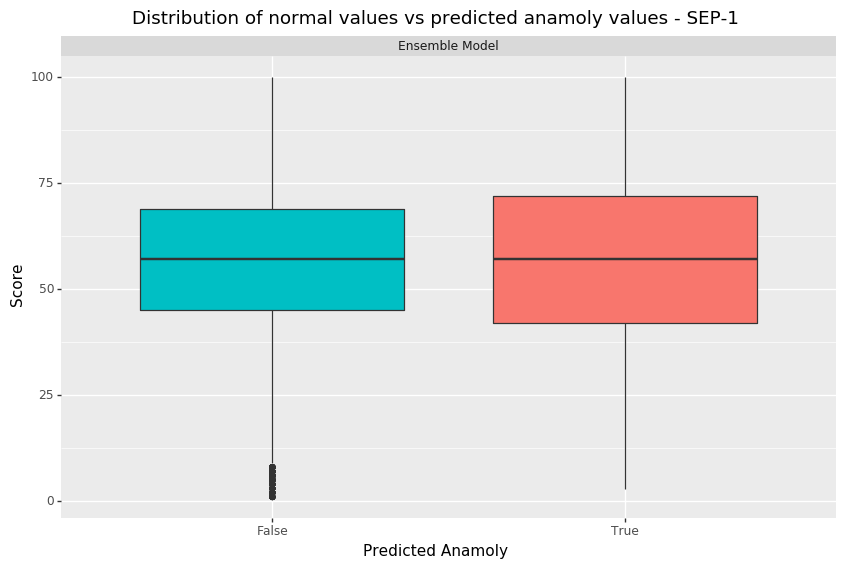

<ggplot: (8760099325465)>

In [71]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamoly values - SEP-1")
 + ylab("Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_wrap('~model')
)

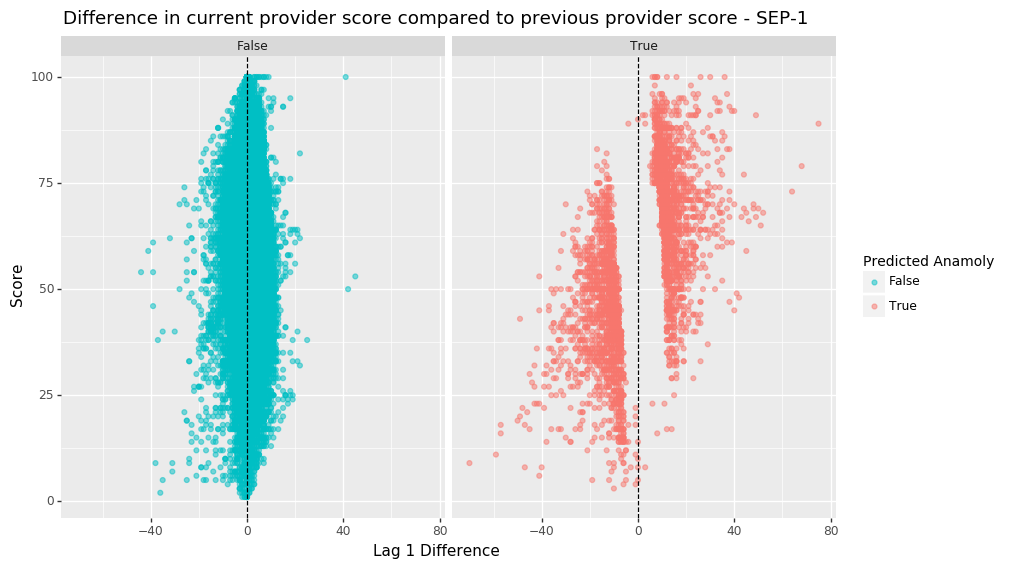

<ggplot: (8760099230689)>

In [72]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score - SEP-1")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.5)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

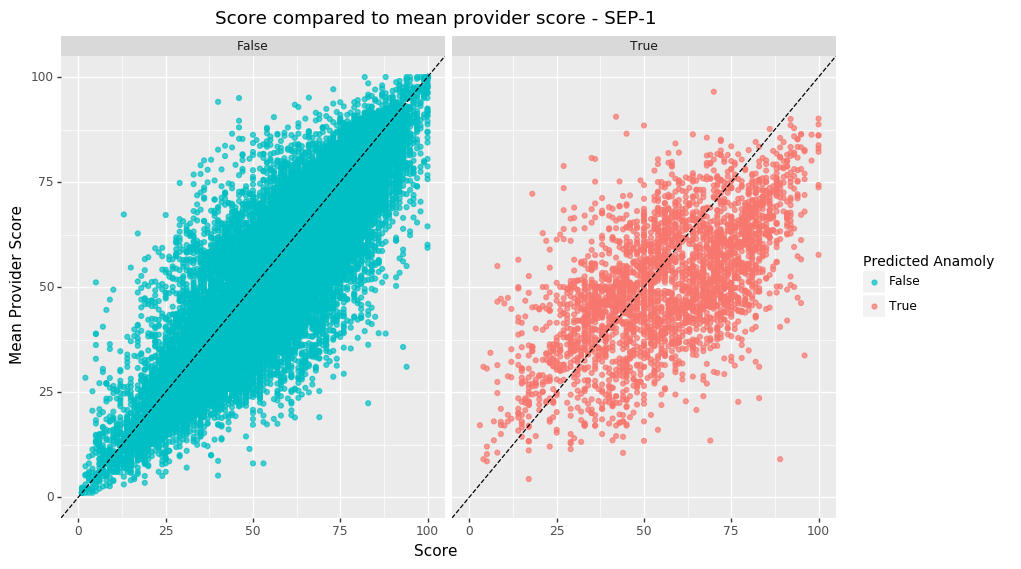

<ggplot: (8760099167089)>

In [73]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score - SEP-1")
 + geom_point(size = 1.5, alpha = 0.7)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

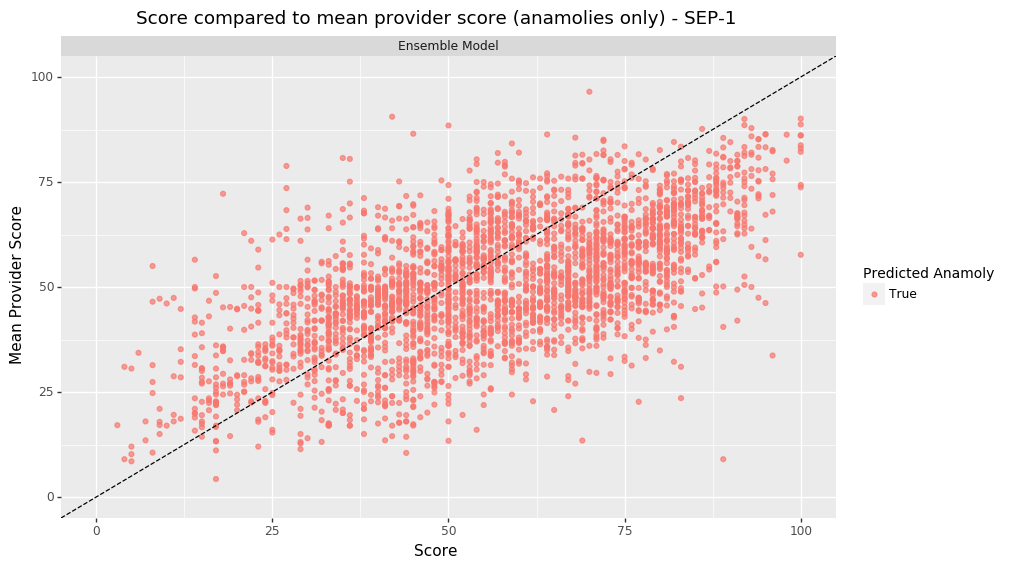

<ggplot: (8760099110993)>

In [74]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model" and outlier == True'),
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only) - SEP-1")
 + geom_point(size = 1.5, alpha = 0.7)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

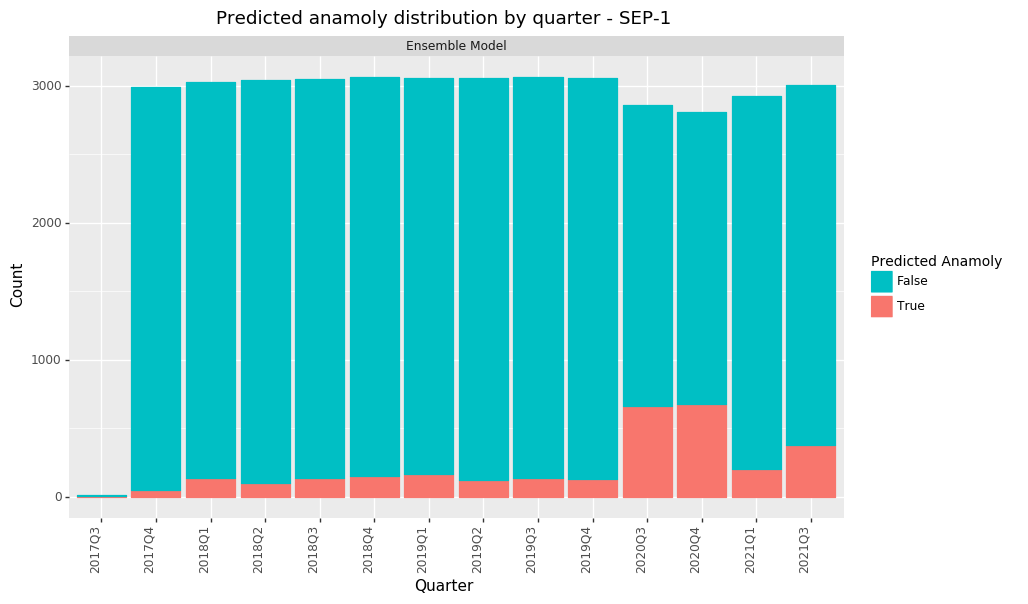

<ggplot: (8760098683029)>

In [75]:
plotnine.options.figure_size = (10,6)
(ggplot(comparison_df.query('model == "Ensemble Model"'),     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted anamoly distribution by quarter - SEP-1")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

In [76]:
comparison_df.query('model == "Ensemble Model"')

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.555952,Ensemble Model
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.982540,Ensemble Model
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,False,20.726967,Ensemble Model
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.937168,Ensemble Model
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.317631,Ensemble Model
...,...,...,...,...,...,...,...,...,...
42330,59.0,2019Q4,90011,49.222222,-2.0,9.777778,False,61.329704,Ensemble Model
42331,62.0,2020Q3,90011,50.200000,3.0,11.800000,False,59.580315,Ensemble Model
42332,62.0,2020Q4,90011,51.272727,0.0,10.727273,False,62.138187,Ensemble Model
42333,65.0,2021Q1,90011,52.166667,3.0,12.833333,False,62.379601,Ensemble Model


## Comparison with Previous Run

In [77]:
from xgboost import XGBRegressor
import pickle

def load_and_predict(id_num, dataset, model_storage_path): 
    model_filename = os.path.join(model_storage_path, "model_id" + str(id_num) + ".pkl")
    if_model = pickle.load(open(model_filename, 'rb'))
    
    #results = if_model.predict(dataset)
    results = if_model.score_samples(dataset) * -1
    
    return results

sep01_filtered_path = "/root/HAIP/notebooks/tmp/filtered_sep_01_dataset.csv"
sep01_dataset = pd.read_csv(sep01_filtered_path)

In [78]:
final_params = {
    'alpha': 2,
    'eta': 0.1,
    'gamma': 2,
    'max_depth': 5,
    'min_child_weight': 8,
    'subsample': 0.8999999999999999
}

model = XGBRegressor(**final_params)
X, y = sep01_dataset[['year', 'quarter', 'lag1']], sep01_dataset[['score']]
model.fit(X, y)

XGBRegressor(alpha=2, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=8,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', ...)

In [79]:
xgb_predicted_score = model.predict(X)
xgb_outlier_prediction = (abs(y['score'] - xgb_predicted_score) > 15)
xgb_sep01_dataset = sep01_dataset.copy()[['score', 'lag1','y_quarter','providerId']]
xgb_sep01_dataset['outlier'] = xgb_outlier_prediction
xgb_sep01_dataset['lag1_diff'] = xgb_sep01_dataset['score'] - xgb_sep01_dataset['lag1']
xgb_sep01_dataset['model'] = "Previous XGBoost Regression"

In [80]:
model_storage_path = '/root/HAIP/notebooks/sep-01-models/isolation_forest/candidate_models/run_2022-10-28-02h31m/'
if_outlier_prediction = load_and_predict(36, sep01_dataset.drop(columns = ['y_quarter', 'providerId', 'lag1']), model_storage_path)
if_sep01_dataset = sep01_dataset.copy()[['score', 'lag1','y_quarter','providerId']]
if_sep01_dataset['outlier'] = if_outlier_prediction > 0.59
if_sep01_dataset['lag1_diff'] = if_sep01_dataset['score'] - if_sep01_dataset['lag1']
if_sep01_dataset['model'] = "Isolation Forest"

In [81]:
old_comparison_df = pd.concat([xgb_sep01_dataset, if_sep01_dataset], axis = 0)
xgb_sep01_dataset['predicted_score'] = xgb_predicted_score

provider_means = (
    sep01_dataset
    .groupby('providerId')['score']
    .mean()
    .reset_index()
    .rename(columns = {'score':'provider_mean_score'})
)

old_comparison_df = old_comparison_df.merge(provider_means, how = 'left', on = 'providerId')
old_comparison_df['prov_mean_diff'] = old_comparison_df['score'] - old_comparison_df['provider_mean_score']
old_comparison_df = old_comparison_df.rename({'lag1':'lag', 'lag1_diff':'lag_diff', 'providerId':'provider_id', 'provider_mean_score':'prov_mean'}, axis = 1)

In [82]:
combined_comparison_df = comparison_df.copy()

In [83]:
comparison_df['Iteration'] = 'New'
old_comparison_df['Iteration'] = 'Previous'
combined_comparison_df = pd.concat([comparison_df, old_comparison_df], axis = 0)
combined_comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,Iteration,lag
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.141809,XGBoost Regression,New,NaN
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.872658,XGBoost Regression,New,NaN
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,False,20.141809,XGBoost Regression,New,NaN
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.839346,XGBoost Regression,New,NaN
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.243614,XGBoost Regression,New,NaN
...,...,...,...,...,...,...,...,...,...,...,...
84585,66.0,2021Q3,670128,79.500000,-6.0,-13.500000,False,NaN,Isolation Forest,Previous,72.0
84586,91.0,2020Q3,670131,83.500000,0.0,7.500000,True,NaN,Isolation Forest,Previous,91.0
84587,87.0,2020Q4,670131,83.500000,-4.0,3.500000,True,NaN,Isolation Forest,Previous,91.0
84588,86.0,2021Q1,670131,83.500000,-1.0,2.500000,True,NaN,Isolation Forest,Previous,87.0


In [84]:
display(comparison_df[['outlier', 'score','model']]
     .rename(columns = {'outlier':'Predicted Outlier',
                        'score':'Score',
                        'model':'Model'})
     .groupby(['Predicted Outlier', 'Model'])
     .describe(percentiles = [.1, .25, .5, .75, .9])
     .transpose()
    .round(1)
)

Predicted Outlier              False                                  \
Model             XGBoost Regression Isolation Forest Ensemble Model   
Score count                  35951.0          38703.0        35962.0   
      mean                      56.5             56.5           56.3   
      std                       17.6             17.5           17.6   
      min                        1.0              1.0            1.0   
      10%                       33.0             33.0           33.0   
      25%                       45.0             45.0           45.0   
      50%                       57.0             57.0           57.0   
      75%                       69.0             69.0           69.0   
      90%                       79.0             79.0           79.0   
      max                      100.0            100.0          100.0   

Predicted Outlier               True                                  
Model             XGBoost Regression Isolation Forest Ensemble Model  
Score count                   3063.0            311.0         3052.0  
      mean                      54.7             40.2           56.6  
      std                       19.8             35.6           19.6  
      min                        2.0              1.0            3.0  
      10%                       29.0              4.0           31.0  
      25%                       41.0              7.0           42.0  
      50%                       55.0             24.0           57.0  
      75%                       70.0             79.0           72.0  
      90%                       81.0             94.0           82.0  
      max                      100.0            100.0          100.0

In [85]:
xgb = combined_comparison_df.query('model == "XGBoost Regression" and Iteration == "Previous"')

summary_table = pd.DataFrame({"outlier count": xgb.loc[ xgb['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": xgb['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier


In [86]:
iforest = combined_comparison_df.query('model == "XGBoost Regression" and Iteration == "Previous"')

summary_table = pd.DataFrame({"outlier count": iforest.loc[ iforest['outlier'] == True, 'y_quarter'].value_counts(),
                              "total": iforest['y_quarter'].value_counts()})
summary_table['% outlier'] = summary_table["outlier count"] / summary_table["total"]
summary_table['% outlier'] = round(summary_table['% outlier']*100,2)
summary_table

,outlier count,total,% outlier


In [87]:
combined_comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,Iteration,lag
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.141809,XGBoost Regression,New,NaN
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.872658,XGBoost Regression,New,NaN
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,False,20.141809,XGBoost Regression,New,NaN
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.839346,XGBoost Regression,New,NaN
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.243614,XGBoost Regression,New,NaN
...,...,...,...,...,...,...,...,...,...,...,...
84585,66.0,2021Q3,670128,79.500000,-6.0,-13.500000,False,NaN,Isolation Forest,Previous,72.0
84586,91.0,2020Q3,670131,83.500000,0.0,7.500000,True,NaN,Isolation Forest,Previous,91.0
84587,87.0,2020Q4,670131,83.500000,-4.0,3.500000,True,NaN,Isolation Forest,Previous,91.0
84588,86.0,2021Q1,670131,83.500000,-1.0,2.500000,True,NaN,Isolation Forest,Previous,87.0


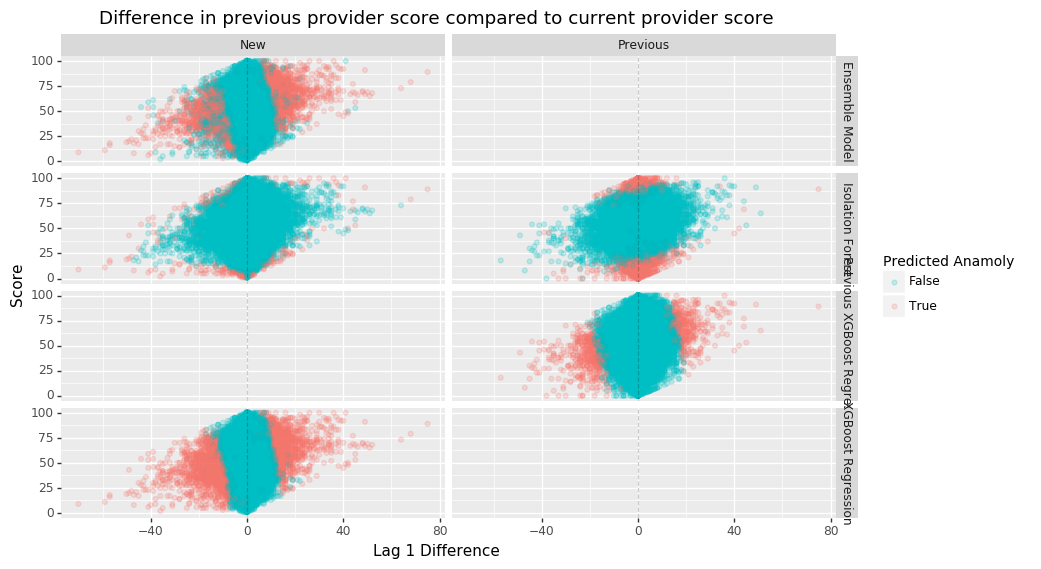

<ggplot: (8760099356041)>

In [88]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df,     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamoly values")
 + ylab("Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_grid('model~Iteration')
)

plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df,     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in previous provider score compared to current provider score")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed', alpha = 0.2)
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
 + facet_grid('model~Iteration')
)

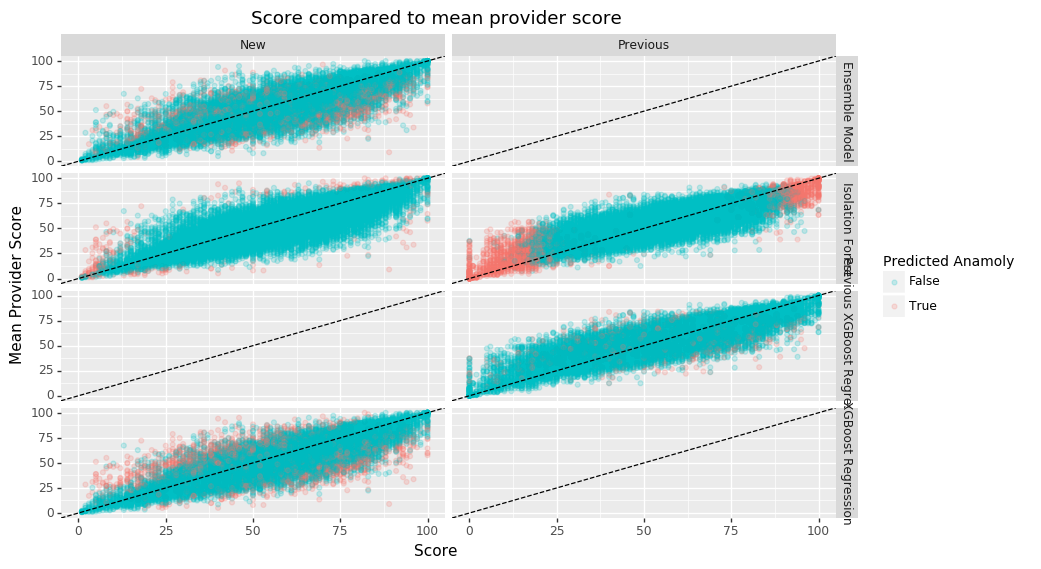

<ggplot: (8760095527645)>

In [89]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df,
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
 + facet_grid('model~Iteration')
)

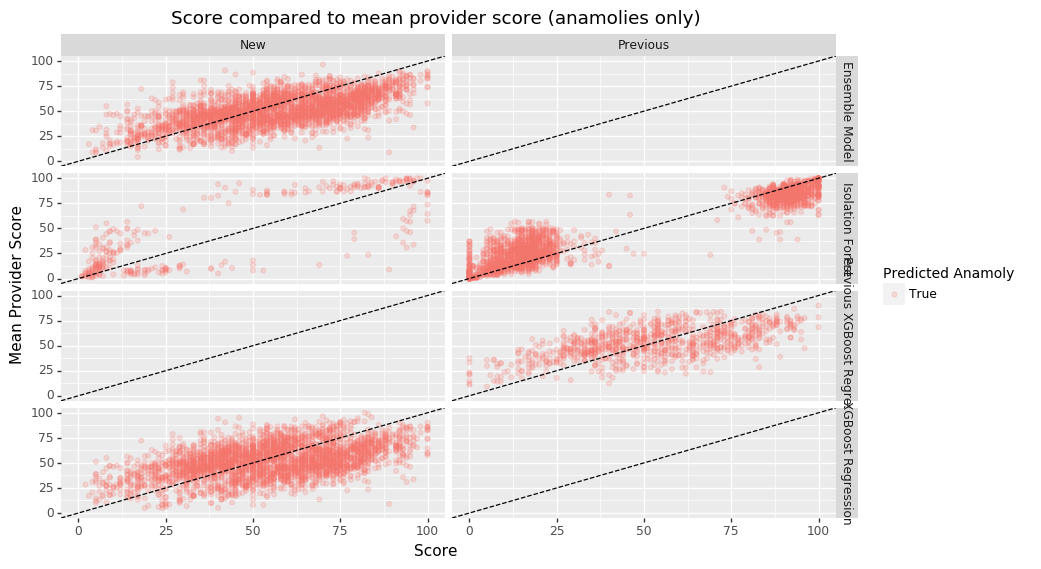

<ggplot: (8760099053953)>

In [90]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df[combined_comparison_df['outlier'] == True],
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only)")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
 + facet_grid('model~Iteration')
)

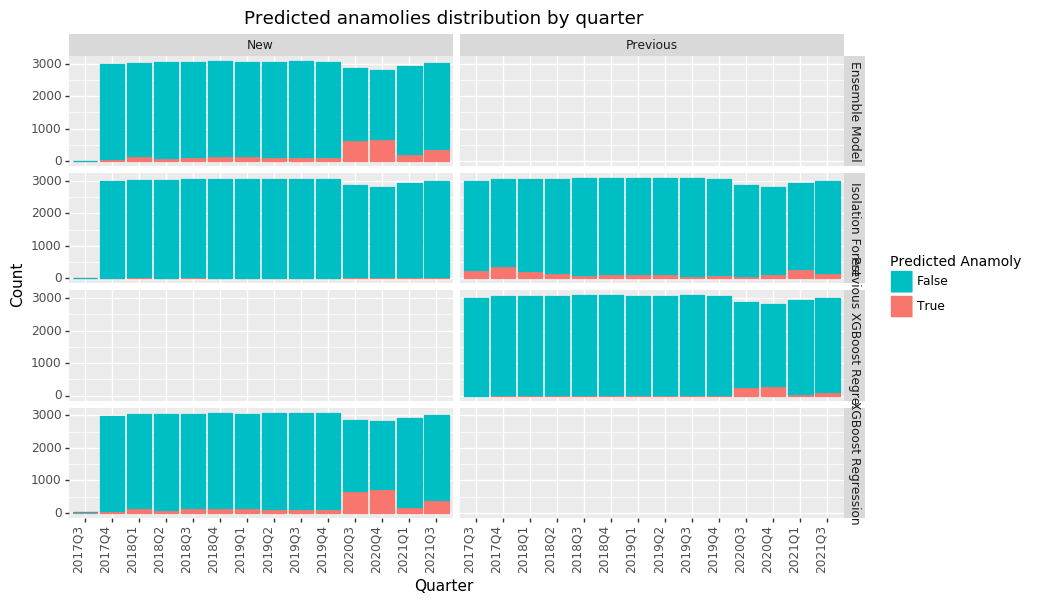

<ggplot: (8760095422921)>

In [91]:
plotnine.options.figure_size = (10,6)
(ggplot(combined_comparison_df,     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted anamolies distribution by quarter")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_grid('model~Iteration')
 + theme(legend_title = element_text(size = 10))
)

## Ensemble vs Regression

In [92]:
versus_comparison_df = combined_comparison_df[
    ((combined_comparison_df['model'] == 'Ensemble Model') & (combined_comparison_df['Iteration'] == 'New')) |
    ((combined_comparison_df['model'] == 'Previous XGBoost Regression') & (combined_comparison_df['Iteration'] == 'Previous'))
]

versus_comparison_df

,score,y_quarter,provider_id,prov_mean,lag_diff,prov_mean_diff,outlier,model_score,model,Iteration,lag
1,19.0,2017Q4,100001,18.000000,1.0,1.000000,False,20.555952,Ensemble Model,New,NaN
2,18.0,2018Q1,100001,18.500000,-1.0,-0.500000,False,20.982540,Ensemble Model,New,NaN
3,26.0,2018Q2,100001,18.333333,8.0,7.666667,False,20.726967,Ensemble Model,New,NaN
4,32.0,2018Q3,100001,20.250000,6.0,11.750000,False,28.937168,Ensemble Model,New,NaN
5,36.0,2018Q4,100001,22.600000,4.0,13.400000,False,34.317631,Ensemble Model,New,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42290,66.0,2021Q3,670128,79.500000,-6.0,-13.500000,False,NaN,Previous XGBoost Regression,Previous,72.0
42291,91.0,2020Q3,670131,83.500000,0.0,7.500000,False,NaN,Previous XGBoost Regression,Previous,91.0
42292,87.0,2020Q4,670131,83.500000,-4.0,3.500000,False,NaN,Previous XGBoost Regression,Previous,91.0
42293,86.0,2021Q1,670131,83.500000,-1.0,2.500000,False,NaN,Previous XGBoost Regression,Previous,87.0


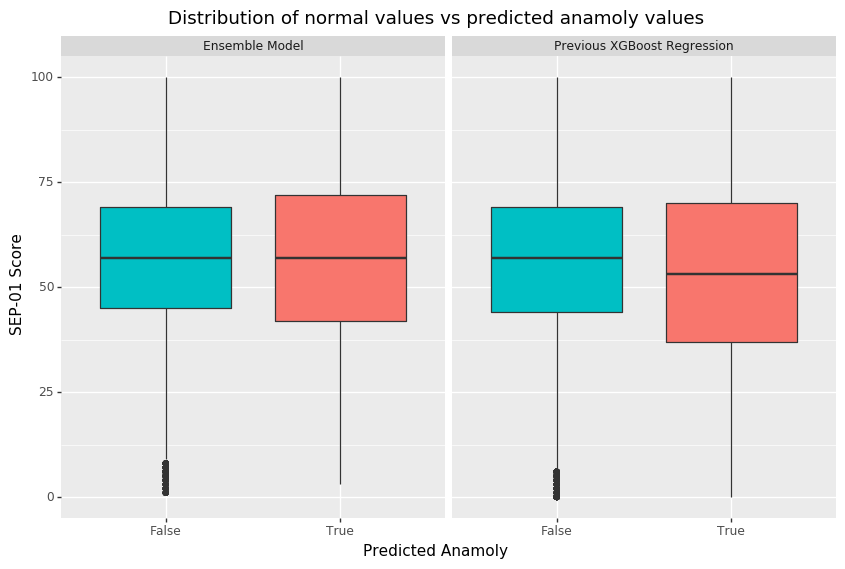

<ggplot: (8760098294753)>

In [93]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df,     
        aes(x = 'outlier',
            y = 'score',
            fill = 'outlier'))
 + ggtitle("Distribution of normal values vs predicted anamoly values")
 + ylab("SEP-01 Score")
 + xlab("Predicted Anamoly")
 + labs(fill = 'Predicted Anamoly')
 + geom_boxplot(show_legend = False)
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + facet_wrap('~model')
)

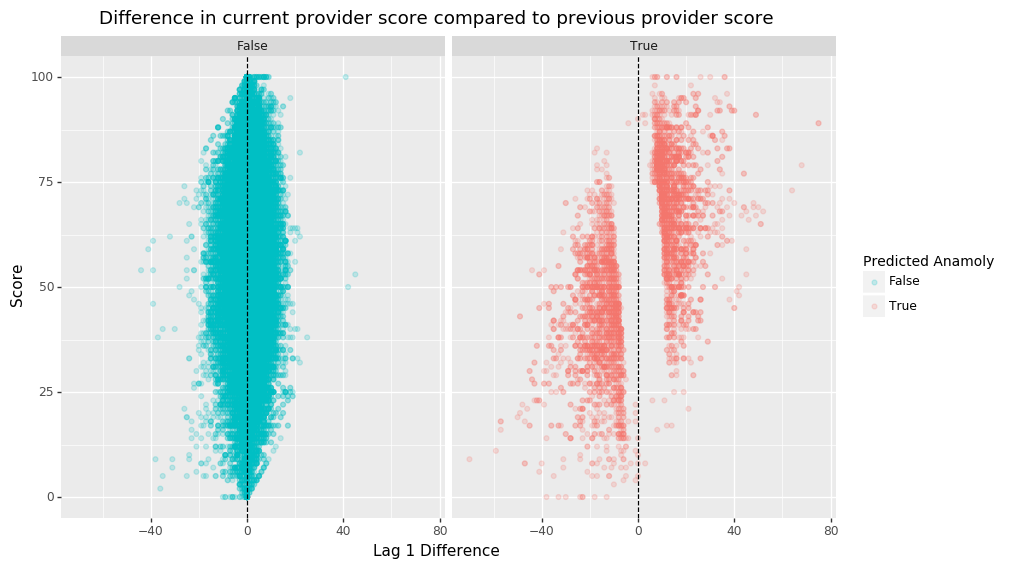

<ggplot: (8760098466377)>

In [94]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df,     
        aes(x = 'lag_diff', 
            y = 'score',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Difference in current provider score compared to previous provider score")
 + xlab("Lag 1 Difference")
 + ylab("Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_point(alpha = 0.2)
 + geom_vline(xintercept = 0, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

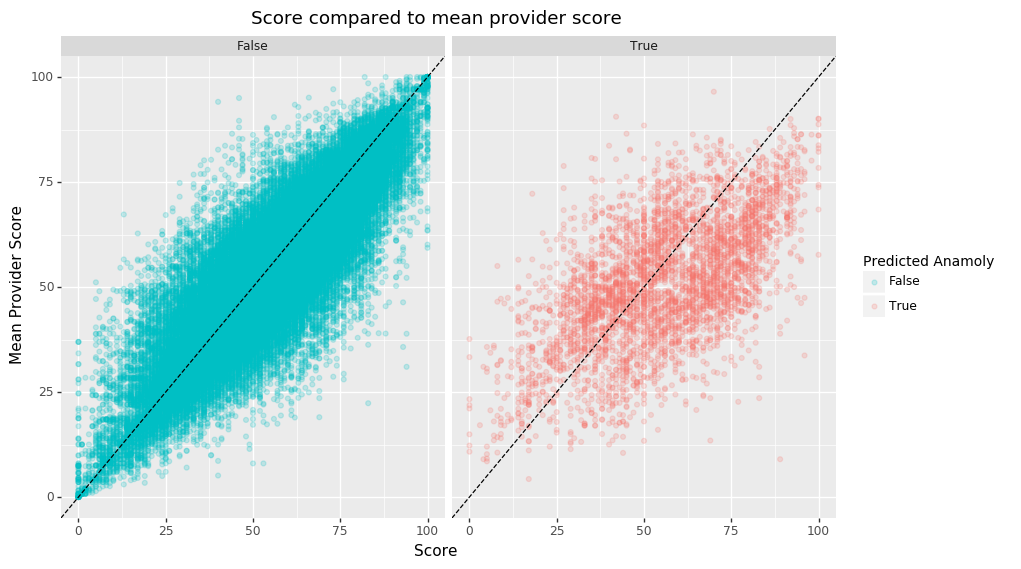

<ggplot: (8760099049197)>

In [95]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df,
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~outlier')
 + theme(legend_title = element_text(size = 10))
)

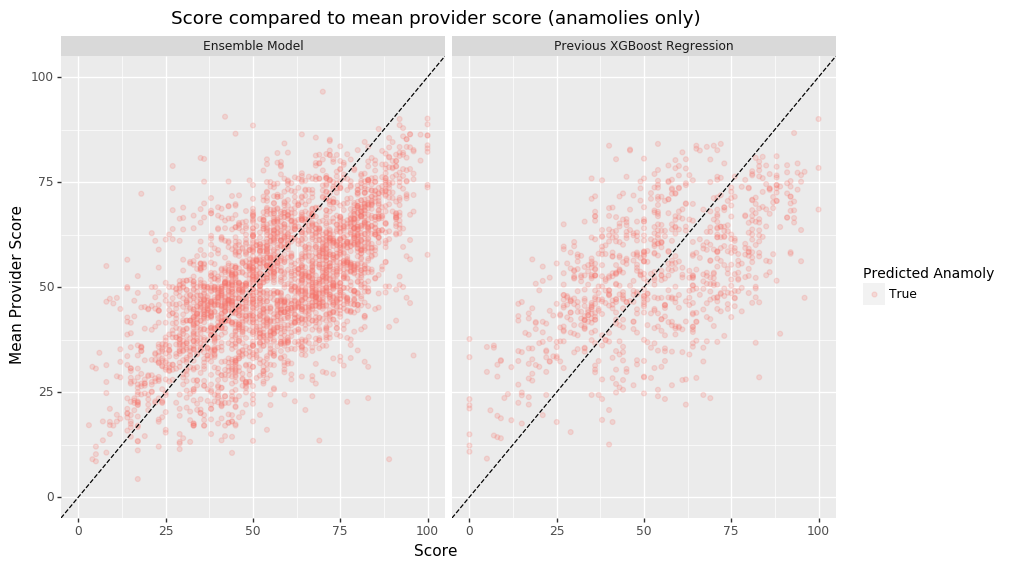

<ggplot: (8760099325493)>

In [96]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df[versus_comparison_df['outlier'] == True],
        aes(x = 'score',
            y = 'prov_mean',
            color = 'outlier'))
 + ggtitle("Score compared to mean provider score (anamolies only)")
 + geom_point(size = 1.5, alpha = 0.2)
 + xlim(0,100)
 + ylim(0,100)
 + xlab("Score")
 + ylab("Mean Provider Score")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#F8766D"])
 + geom_abline(intercept = 0, slope = 1, linetype = 'dashed')
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)

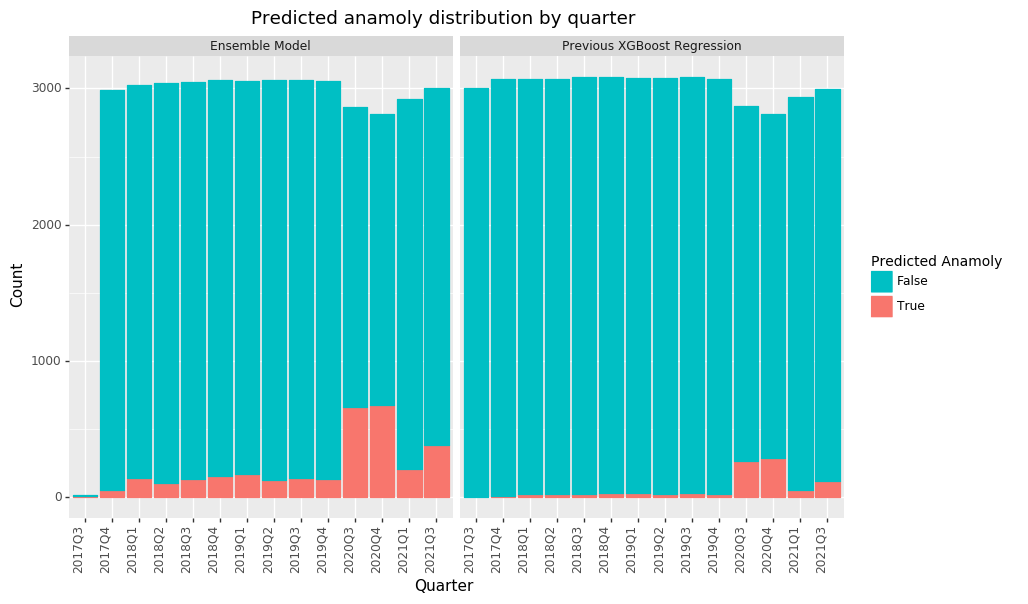

<ggplot: (8760098678453)>

In [97]:
plotnine.options.figure_size = (10,6)
(ggplot(versus_comparison_df,     
        aes(x = 'y_quarter',
            color = 'outlier',
            fill = 'outlier'))
 + ggtitle("Predicted anamoly distribution by quarter")
 + xlab("Quarter")
 + ylab("Count")
 + labs(fill = 'Predicted Anamoly', color = 'Predicted Anamoly')
 + scale_color_manual(values = ["#00BFC4", "#F8766D"])
 + scale_fill_manual(values = ["#00BFC4", "#F8766D"])
 + geom_bar()
 + theme(axis_text_x = element_text(rotation=90, hjust=1))
 + facet_wrap('~model')
 + theme(legend_title = element_text(size = 10))
)